In [1665]:
import sys 
import os 
sys.path.append(os.path.abspath("/Users/niq/Desktop/ThesisIBM/CODE/Giulia/lattice-models-notebooks/lattice-model"))

from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
import numpy as np
import qutip as qt

from lattice.operators.qiskit_aqua_operator_utils import operator_sum
from lattice.wilson_fermions.basic_operators import psi, psidag, U, Udag, standard_basis, fermion_id, link_id


from lattice.lattice import *
import lattice.wilson_fermions as wf
from lattice.wilson_fermions.qiskit_utils import * 
from IPython.display import display
from qiskit.aqua.operators.legacy import WeightedPauliOperator
from lattice.operators.spin_operators import *
from lattice.wilson_fermions.states import *

#from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ

from qiskit.aqua.algorithms import ExactEigensolver, VQE
#from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.components.optimizers import SPSA, COBYLA, L_BFGS_B

from lattice.wilson_fermions.variational_form import *
from lattice.wilson_fermions.variational_form2 import *
from qiskit.aqua.components.initial_states import Zero, Custom

import scipy.linalg

In [283]:
@property
def prt(self):
    print(self.print_details())


def prt_with_output(self):
    return self.print_details()

setattr(WeightedPauliOperator, 'prt', prt)
#repr prende print(str), così qunado scriviamo il weighted operator mi da subito il print 
setattr(WeightedPauliOperator, '__repr__', prt_with_output)

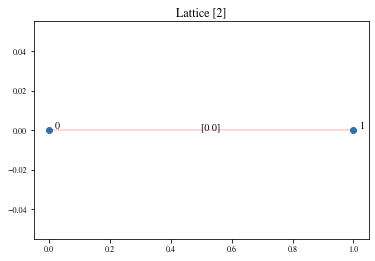

In [1689]:

lattice=SquareLattice([2])
lattice.plot_2d()


rep=wf.dirac

S=0.5
N = 2
params = {
    'm': 1, # The fermionic mass
    't': 1., # A strength parameter for the hopping
    'r': 1., # The Wilson parameter
    'a': 1., # The lattice spacing
    'e': 4, # The charge parameter in the Dirac equation
    'S': S,   # The parameter determining the Gauge field truncation
    'theta': 0.5
}
initial_flux = 0.5
boundary_conditions = {
    (0,0): initial_flux,
    (N-1,0): initial_flux
}

In [1690]:
#init_state=DiracState("..", [0], S=S)

#A=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state)

H=wf.build_hamilton(lattice=lattice, params=params, rep=rep, boundary_cond=boundary_conditions, lam=0, output="qiskit")

H.chop()

init_state=DiracState("..", [0.5], S=S)
init_circ=init_state.construct_circuit("circuit")



##### Building the Hamiltonian #########
Mass, Hopping & Wilson energy added.
0.5
Gauge field flux energy added.
Gauge invariance regulator added.
##### Hamiltonian successfully built #####


In [1691]:
q_init_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=[0,0,0])
# voglio passare da un circuito a uno stato

n_qubits = lattice.nsites * 2 + lattice.nedges * int(np.ceil(np.log2(2 * params['S'] + 1)))

In [1692]:
### ho creato un circuito dalla variational form con dei parametri settati a 0 e ho verificato in effetti che non mi ha cambiato nulla del mio state 
state_decompose_dirac(state=q_init_circ, fermi_len=lattice.nsites, spin_len= lattice.nedges, S=params["S"], thres=0.1 )



([('..', [0.5])], array([1.]))

### QUesto vuoldire che se trovo il modo di fare evolvere i parametri in modo intelligente, cioé rispetto l'evoluzione temporale, ad ogni step posso salvare lo stato che corrisponde a quel circuito. 
Esempio : ho capito come evolvono parametri doo un certo dt, parto da [0,0,0] arrivo a [1,2,0], allora il mio stato all'istante [1,2,0] sarà quello che esce da quella scomposizione


In [1634]:
WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).num_parameters

3

### provo a fareun trotter con questi dati


In [1635]:
# prendi stesso initial vect come sotto 


init_state2=plotvect2(WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=[0,0,0]))

state_decompose_dirac(state=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=[0,0,0]), fermi_len=lattice.nsites, spin_len= lattice.nedges, S=params["S"], thres=0.1)


([('..', [0.5])], array([1.]))

In [1636]:
isinstance(init_state, DiracState)

True

numpy.ndarray

1. Constructing trotter step
2. Extracting trotter matrix
3. Running time evolution
forcasted total time: 0.0s
completed 60 of 60 in time 0.000s   -   0.0s left
total time elapsed: 0.0625s
TOTAL TIME: 0.066s


Text(0.5, 1.0, 'Probability of observing initial state')

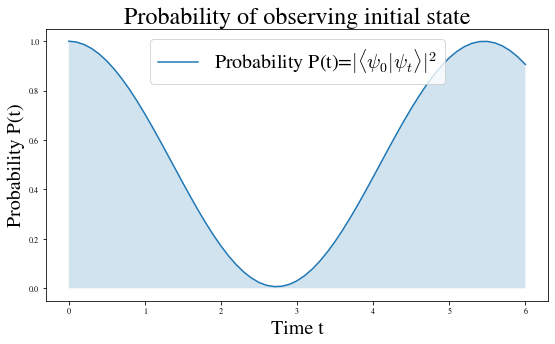

In [1637]:
init_state=DiracState("..", [0.5], S=S)

#init_state2=plotvect2(WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=[1,0,0]))

tstep=0.1
nstep=60

[time,evolve,qmatrix]=qiskit_trotter_simulate(Hamilton=H,init_state=init_state, t_stepsize=tstep, nsteps=nstep)

overlaps_prob= np.asarray([ np.square(np.abs(qiskit_overlap(init_state.construct_circuit("vector").flatten(), evolve))) for evolve in evolve])


plt.figure(figsize=(9,5))
plt.plot(time,overlaps_prob, label=r'Probability P(t)=$|\langle \psi_0 | \psi_t \rangle|^2$')
plt.fill_between(time, 0, overlaps_prob, alpha=0.2)
plt.legend(fontsize=20)
plt.xlabel('Time t', fontsize=20)
plt.ylabel('Probability P(t)', fontsize=20)
plt.title('Probability of observing initial state', fontsize=24)

In [1638]:
import qiskit
qiskit.__qiskit_version__


{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.1'}

In [63]:
### proof of the hadarmard test 

In [64]:
M_simulator= Aer.get_backend(name='qasm_simulator')
S_simulator = Aer.get_backend(name='statevector_simulator')
def plotvect(circ):
    backend=Aer.get_backend("statevector_simulator")
    statevect=execute(circ,backend=S_simulator).result().get_statevector()
    print(round(statevect[0],3),"|0> + ", round(statevect[1], 3), " |1>  " )
    return statevect

def Measure(circ, Shots=1024, compbasis=True):
    counts=execute(circ, shots=Shots,backend=M_simulator).result().get_counts()
    p0=counts["0"]/Shots
    p1=counts["1"]/Shots
    if compbasis:
        print( "prob getting |0> ", p0 , " \n", "prob getting |1> ", p1 , " \n", '\n{ |0> , |1> } Basis - Energy Expectation Value: ',round( (p0)+(-1.0*p1) ,3) )
    else:
        print( '\n{ |+> , |-> } Basis - Energy Expectation Value: ',round( (p0)+(-1.0*p1) ,3) )
    return p0, p1

In [65]:
pi=np.pi
qregs=QuantumRegister(2,name="q")
cregs=ClassicalRegister(1,name="c")

circ=QuantumCircuit(qregs, cregs)
circ.h(0)
circ.x(1)
circ.cu3(3/4*pi,-3/4*pi,3/4*pi,qregs[0],qregs[1])
#circ.u3(pi/2,pi/2,pi/2,1)
circ.h(0)
circ.measure(qregs[0], cregs)
print(circ)

job = execute(circ, backend=Aer.get_backend("statevector_simulator"))
job.result().get_statevector()
p0,p1= Measure(circ,Shots=4000)
#devo confrontare la media della misura !! 

     ┌───┐                       ┌───┐┌─┐
q_0: ┤ H ├───────────■───────────┤ H ├┤M├
     ├───┤┌──────────┴──────────┐└───┘└╥┘
q_1: ┤ X ├┤ U3(3π/4,-3π/4,3π/4) ├──────╫─
     └───┘└─────────────────────┘      ║ 
c: 1/══════════════════════════════════╩═
                                       0 
prob getting |0>  0.6855  
 prob getting |1>  0.3145  
 
{ |0> , |1> } Basis - Energy Expectation Value:  0.371


In [66]:
pi=np.pi
qregs=QuantumRegister(1,name="qregs")
circ=QuantumCircuit(qregs,name='circ')
circ.x(0)
circ.u3(3/4*pi,-3/4*pi,3/4*pi,0)
statevect=plotvect(circ)

circ.measure_all()

print(circ)

job = execute(circ, backend=Aer.get_backend(name='qasm_simulator'), shots=1024)

#job.result().get_statevector()
counts=job.result().get_counts()
counts
### prova vogliamo calcolare la media di questo stato  prima direttamente, poi con l'hadamard test di sopra 
Measure(circ=circ,Shots=4000)

# prendo il vettore (01) che é il nostro psi 
init_vect=np.array([0,1])
print(np.real(np.round(np.inner(init_vect.conj(), statevect),3)))
# per trovare il risultato tanto agongato o prendo la sqareroot di prob(1), oppure prendo la moltilplicazione dei due state vector !! 

(0.653-0.653j) |0> +  (0.383+0j)  |1>  
         ┌───┐┌─────────────────────┐ ░ ┌─┐
qregs_0: ┤ X ├┤ U3(3π/4,-3π/4,3π/4) ├─░─┤M├
         └───┘└─────────────────────┘ ░ └╥┘
 meas: 1/════════════════════════════════╩═
                                         0 
prob getting |0>  0.8475  
 prob getting |1>  0.1525  
 
{ |0> , |1> } Basis - Energy Expectation Value:  0.695
0.383


### viene abbastanza giusto Nota che se 

In [67]:
# ora usiamo il circuito della variational form 


In [68]:
np.sqrt(0.1475 )

0.3840572873934304

In [69]:
### il nostro psi ora é il dirac state 
from qiskit.converters.circuit_to_instruction import *
from qiskit.circuit.library.standard_gates import HGate
qre=QuantumRegister(H.num_qubits+1,"q")

Ultimate=QuantumCircuit(qre)

## nota che ho tolto initial state !!! 
cir=WilsonLGT2(lattice=lattice, S=S, rep=rep).construct_circuit(parameters=[0,0,0]).decompose()

init_circ=DiracState("..",[0.5],S=S).construct_circuit("circuit")
init_ist=circuit_to_instruction(init_circ)
inst=circuit_to_instruction(cir)

custom = cir.to_gate().control(1)
Ultimate.append(init_ist,[1,2,3,4,5])
Ultimate.append(custom,[0,1,2,3,4,5])
Ultimate.draw()


### cosi abbbiamo il nostro initial state


q_0: ───────────────────────■────────
     ┌──────────────┐┌──────┴───────┐
q_1: ┤0             ├┤0             ├
     │              ││              │
q_2: ┤1             ├┤1             ├
     │              ││              │
q_3: ┤2 circuit3336 ├┤2 circuit3326 ├
     │              ││              │
q_4: ┤3             ├┤3             ├
     │              ││              │
q_5: ┤4             ├┤4             ├
     └──────────────┘└──────────────┘

In [70]:
help(QuantumCircuit.to_gate)

Help on function to_gate in module qiskit.circuit.quantumcircuit:

to_gate(self, parameter_map=None, label=None)
    Create a Gate out of this circuit.
    
    Args:
        parameter_map(dict): For parameterized circuits, a mapping from
           parameters in the circuit to parameters to be used in the
           gate. If None, existing circuit parameters will also
           parameterize the gate.
        label (str): Optional gate label.
    
    Returns:
        Gate: a composite gate encapsulating this circuit
        (can be decomposed back)



In [71]:
## voglio costruire la derivata della var form 
##### la prima é tipo un hopping like term che dipende dal sito in cui ci troviamo e dalla coupling matrice 



def Varder(edge, lattice, S, mixmat=np.array([[0,0],[1,0]]), hopp_coeff=1., output='qiskit'):

    site = lattice.site_vector(edge[0])
    hopping_dim = edge[1]

    # 2. Generate the hopping term as a sum over the fermionic (spinor) components
    summands = []
    # 2.1 Check for boundary sites
    # Treat open and closed boundary conditions (skip term if edge is at boundary)
    is_at_boundary = lattice.is_boundary_along(site, hopping_dim, direction='positive')
    if is_at_boundary:
        # print('encountered boundary at {}, {}'.format(site, j))
        raise UserWarning('The given `site` and `hopping_dim` combination goes outside the lattice.')

    # 2.2Get the edge along which hopping takes place and the next site
    next_site = lattice.project(site + standard_basis(hopping_dim, lattice.ndim))



    # 3 Sum over all spinor components:
    for alpha in range(2):
        for beta in range(2):
            # Skip cases with zero coefficients
            if mixmat[alpha, beta] == 0:
                # print('skipped ab {}, {}'.format(alpha, beta))
                continue

            # Generate the fermionic hopping terms
            bwd_hopp = (hopp_coeff
                        * psidag(site, alpha, lattice)
                        * mixmat[alpha, beta]
                        * psi(next_site, beta, lattice))
            fwd_hopp = bwd_hopp.dag()

            # If gauge field is present, tensor with the hopping terms with the link operators
            if S > 0:
                bwd_hopp = bwd_hopp @ U(edge, S, lattice)
                fwd_hopp = fwd_hopp @ Udag(edge, S, lattice)

            # Convert the operators to qubit operators and add them to the total hopping term
            if not output == 'abstract':
                bwd_hopp = bwd_hopp.to_qubit_operator(output=output)
                fwd_hopp = fwd_hopp.to_qubit_operator(output=output)

            summands += [fwd_hopp, bwd_hopp]

    # 5. Sum up all hopping terms and return the hopping hamilton_qiskit
    hopping_term = operator_sum(summands)
    if output == 'qiskit':
        hopping_term.chop()
    return hopping_term

In [72]:
#questo potrebbe essere ilp rimo termine che devo trovare l'exp value 
Varder([0,0],lattice=lattice, S=params["S"])

In [73]:
from lattice.wilson_fermions.basic_operators import psi, psidag, U, Udag, standard_basis, fermion_id, link_id


INII 	 2.0
NIII 	 1.0

In [598]:
def numb(site, lattice, rep=dirac, m=1., S=0, lam=1):
    """Constructs the observable corresponding to the mass (in the low energy limit)
     at lattice site `site` . """
    ide = np.array([[1,0],[0,lam]])

    summands = []
    # 1. sum over all spinor components at the given lattice site
    for alpha in range(2):
        for beta in range(2):
            summands.append(psidag(site, alpha, lattice) * ide[alpha, beta] * psi(site, beta, lattice))
    mx = m * operator_sum(summands)

    # 2. If we are working with interacting Wilson fermions (S>0), tensor with an identity on the spin register
    if S > 0:
        mx = mx @ link_id(S, lattice)

    return mx

In [600]:
varu=WilsonLGT2(lattice=lattice,S=params["S"], rep=dirac,initial_state=DiracState("..",[0.5],S=params["S"]))
varu.construct_circuit(parameters=[0,2,3]).draw()

┌───┐┌─────────────┐         
 fermionic_0: ┤ X ├┤0            ├─────────
              └───┘│             │┌───────┐
 fermionic_1: ─────┤1            ├┤ RZ(2) ├
              ┌───┐│             │└───────┘
 fermionic_2: ┤ X ├┤2 h_[0 0](0) ├─────────
              └───┘│             │┌───────┐
 fermionic_3: ─────┤3            ├┤ RZ(3) ├
                   │             │└───────┘
spin(0.5)0_0: ─────┤4            ├─────────
                   └─────────────┘

In [599]:
hallo=construct_trotter_step(numb(site=[0], lattice=lattice, S=0.5,lam=2).to_qubit_operator(output='qiskit'), 1)
print(repr(numb(site=[0], lattice=lattice, S=0.5).to_qubit_operator(output='qiskit')))
hallo2=construct_trotter_step(numb(site=[1], lattice=lattice, S=0.5, lam=3).to_qubit_operator(output='qiskit'), 1)
cirq=QuantumCircuit(5,name="qc")
cirq.append(hallo, qargs=cirq.qubits)
cirq.append(hallo2, qargs=cirq.qubits)
cirq.decompose().draw()

IIIII	(1+0j)
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)



┌───────┐
q_0: ┤ RZ(1) ├
     ├───────┤
q_1: ┤ RZ(2) ├
     ├───────┤
q_2: ┤ RZ(1) ├
     ├───────┤
q_3: ┤ RZ(3) ├
     └───────┘
q_4: ─────────

In [610]:
cir=QuantumCircuit(1)
cir.rz(1,0)
print(cir)
statevector=plotvect2(cir)
statevector

     ┌───────┐
q_0: ┤ RZ(1) ├
     └───────┘


array([0.87758256-0.47942554j, 0.        +0.j        ])

In [699]:
### occhio che lambda c'é solo nella moltiplicazione del primo termine !!! 
## l'identità non é un'identita!!! 
def termlambda(site, lattice, rep=dirac, m=1., S=0):
    """Constructs the observable corresponding to the mass (in the low energy limit)
     at lattice site `site` . """
    ide = np.array([[0,0],[0,1]])

    summands = []
    # 1. sum over all spinor components at the given lattice site
    for alpha in range(2):
        for beta in range(2):
            summands.append(psidag(site, alpha, lattice) * ide[alpha, beta] * psi(site, beta, lattice))
    mx = m * operator_sum(summands)

    # 2. If we are working with interacting Wilson fermions (S>0), tensor with an identity on the spin register
    if S > 0:
        mx = mx @ link_id(S, lattice)

    return mx

In [700]:
##3 c'é una bella differenza tra i due!! 
print(repr(numb(site=[0], lattice=lattice, S=0.5).to_qubit_operator(output='qiskit')))
termlambda(site=[0], lattice=lattice, S=0.5).to_qubit_operator(output='qiskit')

IIIII	(1+0j)
IIIIZ	(0.5+0j)
IIIZI	(0.5+0j)



IIIII	(0.5+0j)
IIIZI	(0.5+0j)

In [701]:
def is_hermitian(C):
    C=to_matrix_operator(C).dense_matrix
    Ch=C.conj().T
    a=0
    for i in range(len(C[0])):
        for j in range(len(C[0])):
            if C[i][j]!=Ch[i][j]:
                a+=1
                
    if a==0:
        return True 
    else:
        return False                 


In [702]:
is_hermitian(H)

True

In [703]:
### ho tre parametri e per ognuno i termini ceh scendono dalla derivata sono questi 

##
## per forza il conj é solo moltiplicazine per -1j visto ceh é una lista di pauli operator! 
term0=Varder(edge=[0,0], lattice=lattice,S=params["S"])*1j
term0conj=Varder(edge=[0,0], lattice=lattice,S=params["S"])*(-1j)

term1=1j*termlambda(site=[0],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')
term1conj=(-1j)*termlambda(site=[0],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')

term2=1j*termlambda(site=[1],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')
term2conj=(-1j)*termlambda(site=[1],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')


### ora voglio trovare oi coefficenti della matrice A 


# derivata per theta0, e theta0, esce
#A[0,0]=(
A={
    "A00":term0conj*term0,
    "A01":term0conj*term1,
    "A02":term0conj*term2,
    "A10":term1conj*term0,
    "A11":term1conj*term1,
    "A12":term1conj*term2,
    "A20":term2conj*term0,
    "A21":term2conj*term1,
    "A22":term2conj*term2,
}

# costrusiamo il vettore C é semplicemente term i conj per l'hamiltoniano 
C={
    "C0": term0conj*H,
    "C1": term1conj*H,
    "C2": term2conj*H
}



In [290]:
print()

In [291]:
# ora noi iniziamo con un certo termine 
#theta_init=[np.pi*3/4,np.pi*3/4,np.pi*3/4]
theta_init=[1,0,0]

q_init_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=theta_init)

state_decompose_dirac(state=q_init_circ, fermi_len=lattice.nsites, spin_len= lattice.nedges, S=params["S"], thres=0.1 )

([('bb', [0.5]), ('..', [0.5]), ('ap', [-0.5])],
 array([0.69994717, 0.16337155, 0.13668128]))

Volgio costruire una funzione che prende la lsita di A e C, e ridà gli exp value rispetto al circuito dato dai parametri. Fai che con quelle matrici posso trovare i nuovi parametri, i nuovi parametri permettono di costruire il nuovo state da cui calcolo i nuovi vaolri dellem matrici. Posso farlo prima in modo esatto, cioé utilizzando gli statevector del circuit, poi in un secondo tempo facendolo con i veri counts!!! 


In [292]:
### exp value, gli dò un operatore in qiskit e uno stato come circuito 

def qiskit_exp_statevect(obs_qiskit, circ):
    state_vect=execute(circ,backend=Aer.get_backend("statevector_simulator")).result().get_statevector().flatten()
    mat=to_matrix_operator(obs_qiskit).dense_matrix
    return np.inner(state_vect.conj(), np.dot(mat, state_vect))

In [293]:
Identity=(fermion_id(lattice)@link_id(lattice=lattice,S=params["S"])).to_qubit_operator(output="qiskit")
qiskit_exp_statevect(Identity,q_init_circ)


(0.9999999999999994+0j)

In [704]:
def get_matrix_vect(A,C,state_circuit=None, params=None):
    Amat=np.zeros([3,3],  dtype=complex)
    Cvect=np.zeros([3], dtype=complex)
    if state_circuit is None:
        if params is None:
            raise NotImplementedError("provide at lest params or state_circuit")
        else:
            state_circuit=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=params)

    Amat[0][0]=qiskit_exp_statevect(A["A00"],state_circuit)
    Amat[0][1]=qiskit_exp_statevect(A["A01"],state_circuit)
    Amat[0][2]=qiskit_exp_statevect(A["A02"],state_circuit)
    Amat[1][0]=qiskit_exp_statevect(A["A10"],state_circuit)
    Amat[1][1]=qiskit_exp_statevect(A["A11"],state_circuit)
    Amat[1][2]=qiskit_exp_statevect(A["A12"],state_circuit)
    Amat[2][0]=qiskit_exp_statevect(A["A20"],state_circuit)
    Amat[2][1]=qiskit_exp_statevect(A["A21"],state_circuit)
    Amat[2][2]=qiskit_exp_statevect(A["A22"],state_circuit)

    Cvect[0]=qiskit_exp_statevect(C["C0"],state_circuit)
    Cvect[1]=qiskit_exp_statevect(C["C1"],state_circuit)
    Cvect[2]=qiskit_exp_statevect(C["C2"],state_circuit)

    return np.real(Amat), np.imag(Cvect)

In [705]:
Amat,Cvec=get_matrix_vect(A=A,C=C,params=[1,0,0])


In [706]:
get_matrix_vect(A=A,C=C,state_circuit=q_init_circ)

(array([[5.95507845e-33, 3.25655801e-34, 6.51311602e-34],
        [3.25655801e-34, 1.00000000e+00, 1.00000000e+00],
        [6.51311602e-34, 1.00000000e+00, 1.00000000e+00]]),
 array([-2.33759637e-33, -8.00000000e+00, -8.00000000e+00]))

In [707]:
## abbiamo bisogno di una funzione che prende circuito e restituisce state vect 
def plotvect2(circ):
    backend=Aer.get_backend("statevector_simulator")
    statevect=execute(circ,backend=backend).result().get_statevector()
    return statevect
## check


In [708]:
### to solve we use that 
def solveG(A,C):
    if np.linalg.det(A)==0:
        invA=np.linalg.pinv(A)
        print("Warning matrix is singular, using np.linalg.pinv(A)")
    else:
        invA=np.linalg.inv(A) 
    return  np.dot(invA,C)   

In [709]:
q_init_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=[np.pi+4*np.pi,0,0])

np.around(plotvect2(q_init_circ),5)

array([ 1.-0.j, -0.+0.j,  0.+0.j, -0.-0.j, -0.-0.j, -0.+0.j, -0.-0.j,
        0.+0.j,  0.-0.j,  0.-0.j,  0.-0.j, -0.-0.j,  0.-0.j,  0.+0.j,
        0.-0.j, -0.+0.j,  0.-0.j,  0.-0.j, -0.+0.j, -0.-0.j,  0.+0.j,
        0.+0.j,  0.+0.j,  0.-0.j,  0.+0.j, -0.+0.j,  0.+0.j,  0.-0.j,
        0.+0.j,  0.+0.j,  0.-0.j, -0.+0.j])

In [904]:

### devo risolvere il caso in cui ci sono eigenvalue negativi !!! 
## ora che ho thetadot posso farel'upload dei theta rispetto a 
"""
tstep=0.1
nstep=50

"""
init_state=DiracState("ap", [-0.5], S=S)

theta_init=[0,0,0]

q_init_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=theta_init)

init_vect=np.around(plotvect2(q_init_circ),5)

state_decompose_dirac(state=q_init_circ, fermi_len=lattice.nsites, spin_len= lattice.nedges, S=params["S"], thres=0.1 )

tfin=5
delta_t=0.1
nstep=tfin/delta_t

t=np.linspace(0, tfin, int(tfin/delta_t))
delta_t=t[-1]/len(t)

evolvevar=[]

theta=theta_init
for i in range(len(t)):
    state_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=theta)
    evolvevar.append(plotvect2(state_circ))
    Amat,Cvec=get_matrix_vect(A=A,C=C,state_circuit=state_circ)
    thetadot=solveG(Amat,Cvec)
    #thetadot=scipy.linalg.solve(Amat,Cvec)
    theta= theta+ delta_t * thetadot
    


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
final_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=theta)

state_decompose_dirac(state=final_circ, fermi_len=lattice.nsites, spin_len= lattice.nedges, S=params["S"], thres=0.1 )

In [ ]:
#compute overlap with initial state 
overlapsvar=np.asarray([ np.square(np.abs(qiskit_overlap(init_vect, evolve))) for evolve in evolvevar])

#overlapsvar=np.asarray([ np.square(np.abs(qiskit_overlap(init_state.construct_circuit("vector").flatten(), evolve))) for evolve in evolvevar])


In [ ]:
plt.figure(figsize=(9,5))
plt.plot(t,overlapsvar,".-" ,label=r'Probability P(t)=$|\langle \psi_0 | \psi_t \rangle|^2$')
plt.fill_between(t, 0, overlapsvar, alpha=0.2)
plt.legend(fontsize=20)
plt.xlabel('Time t', fontsize=20)
plt.ylabel('Probability P(t)', fontsize=20)
plt.title('Probability of observing initial state', fontsize=24)

In [ ]:
problistvar = np.array([[np.square(np.abs(qiskit_overlap(split_state.full().flatten(), state.flatten()))) for state in evolvevar] 
                     for split_state in split_states])
other = 1 - np.sum(problistvar, axis=0)
problistvar = np.vstack((problistvar, other))



thres=0.0
# 1. Extract the relevant rows in the probability list depending on the threshold:
relevant_indices = np.unique(np.where(problistvar > thres)[0])

relevant_labels = labellist[relevant_indices]
relevant_probs =  problistvar[relevant_indices]
colors=['C0',
        'darkgreen', 'forestgreen', 'mediumseagreen', 'limegreen','lawngreen','yellowgreen',
        'maroon', 'firebrick', 'red',
        'grey']

# 2. Plot
baseline = np.zeros_like(t)
for line, label, color in zip(np.cumsum(relevant_probs, axis=0), relevant_labels, colors):
    plt.plot(t, line, color=color, label=label)
    plt.fill_between(t, baseline, line, alpha=0.4, color=color)
    baseline = line

plt.legend(loc='lower center', ncol=2, fontsize=axes_size);
plt.xlim((0,t[-1]))
plt.ylim((0,1))
#sns.despine()
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title(r'String breaking ($m \ll e$): Splitting of probabilities', fontsize=title_size)
plt.ylabel(r'State probability', fontsize = axes_size)
plt.xlabel(r'Time $t$', fontsize = axes_size);
plt.savefig(overleafpath + 'string_breaking_probability_split.pdf')

1. Constructing trotter step
2. Extracting trotter matrix
3. Running time evolution
forcasted total time: 0.0s
completed 50 of 50 in time 0.000s   -   0.0s left
total time elapsed: 0.0665s
TOTAL TIME: 0.067s


Text(0.5, 1.0, 'Probability of observing initial state')

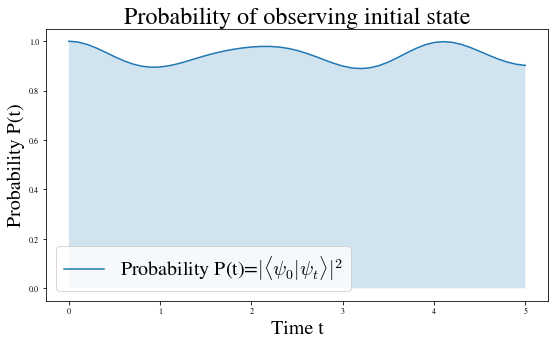

In [1470]:
#init_state=DiracState("..", [0.5], S=S)


tstep=0.1
nstep=50

[time,evolve,qmatrix]=qiskit_trotter_simulate(Hamilton=H,init_state=init_state, t_stepsize=tstep, nsteps=nstep)

overlaps_prob= np.asarray([ np.square(np.abs(qiskit_overlap(init_vect, evolve))) for evolve in evolve])


plt.figure(figsize=(9,5))
plt.plot(time,overlaps_prob, label=r'Probability P(t)=$|\langle \psi_0 | \psi_t \rangle|^2$')
plt.fill_between(time, 0, overlaps_prob, alpha=0.2)
plt.legend(fontsize=20)
plt.xlabel('Time t', fontsize=20)
plt.ylabel('Probability P(t)', fontsize=20)
plt.title('Probability of observing initial state', fontsize=24)

In [314]:
# Latex \textwidth: 426.79134pt
def set_size(width, fraction=1, subplot=[1,1]):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplot[0] / subplot[1])

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

thesis_width = 426.79134
optimal_figsize = set_size(thesis_width)

import matplotlib as mpl
import matplotlib.pyplot as plt

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        # Set the font
        'mathtext.fontset': 'cm',
        'font.family': 'STIXGeneral'
}

#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams.update(nice_fonts)

title_size = 12
tick_size = 8
label_size = 8
axes_size = 10
figsize = optimal_figsize

#overleafpath = '/Users/ima/Dropbox/Apps/Overleaf/Master Thesis/'
overleafpath = '/Users/niq/Desktop/ThesisIBM/plot/ '

In [315]:
def draw_config(fermis, spins):
    
    #spin_mapping = {
     #   1: "\u2192",
      #  0: "~",
      #  -1: "\u2190"}

    spin_mapping = {
        0.5: "\u2192",
        -0.5: "~"}    
    
    fermi_mapping = {
        'p': 'p', 
        '.': 'o',
        'a': 'a',
        'b': 'b'
    }
  
    mystr = ''
    i = 0
    for fermi, spin in zip(fermis, spins):
        mystr += fermi_mapping[fermi] + spin_mapping[spin]
        
    if len(fermis) > len(spins):
        mystr += fermi_mapping[fermis[-1]]
        
    return mystr 

In [316]:
split_states = [DiracState("ap",[-0.5],S=params["S"]).construct_circuit("qutip") ,DiracState("..",[0.5],S=params["S"]).construct_circuit("qutip"),
DiracState(".b",[0.5],S=params["S"]).construct_circuit("qutip"),
DiracState("b.",[0.5],S=params["S"]).construct_circuit("qutip"),
DiracState("bb",[0.5],S=params["S"]).construct_circuit("qutip")]

labellist = np.array([draw_config(*state_decompose_dirac(state, 
                                         fermi_len=lattice.nsites, 
                                         spin_len=lattice.nedges, S=S, output='other')[0][0])
             for state in split_states] + ['other'])

problist = np.array([[np.square(np.abs(qiskit_overlap(split_state.full().flatten(), state.flatten()))) for state in evolve] 
                     for split_state in split_states])
other = 1 - np.sum(problist, axis=0)
problist = np.vstack((problist, other))


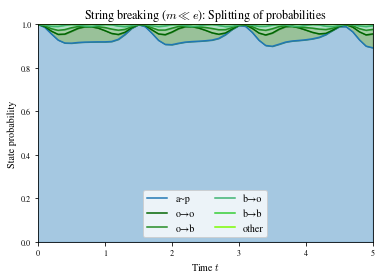

In [317]:
thres=0.0
# 1. Extract the relevant rows in the probability list depending on the threshold:
relevant_indices = np.unique(np.where(problist > thres)[0])

relevant_labels = labellist[relevant_indices]
relevant_probs =  problist[relevant_indices]
colors=['C0',
        'darkgreen', 'forestgreen', 'mediumseagreen', 'limegreen','lawngreen','yellowgreen',
        'maroon', 'firebrick', 'red',
        'grey']

# 2. Plot
baseline = np.zeros_like(time)
for line, label, color in zip(np.cumsum(relevant_probs, axis=0), relevant_labels, colors):
    plt.plot(time, line, color=color, label=label)
    plt.fill_between(time, baseline, line, alpha=0.4, color=color)
    baseline = line

plt.legend(loc='lower center', ncol=2, fontsize=axes_size);
plt.xlim((0,5))
plt.ylim((0,1))
#sns.despine()
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title(r'String breaking ($m \ll e$): Splitting of probabilities', fontsize=title_size)
plt.ylabel(r'State probability', fontsize = axes_size)
plt.xlabel(r'Time $t$', fontsize = axes_size);
plt.savefig(overleafpath + 'string_breaking_probability_split.pdf')

LinAlgError: Singular matrix

array([1., 1., 1.])

-47.999999999999986

In [728]:
### occhio che commutano
circ1=QuantumCircuit(1)
circ2=QuantumCircuit(1)

circ1.x(0)
circ1.y(0)
circ2.y(0)
circ2.x(0)
print(plotvect2(circ1))
print(plotvect2(circ2))

mat=execute(circ1, backend=Aer.get_backend("unitary_simulator")).result().get_unitary()
print(mat)
#circ1.append(circ2,qargs=circ2.qubits)
circ1.draw()


[0.-1.j 0.+0.j]
[0.+1.j 0.-0.j]
[[0.-1.j 0.-0.j]
 [0.+0.j 0.+1.j]]


┌───┐┌───┐
q_0: ┤ X ├┤ Y ├
     └───┘└───┘

In [571]:
cacc=np.array([1,2,3,4])
cacc[1::2]
H.num_qubits

5

In [539]:
#### prove !!!!!! 


### nota che il termine 
term0 ### non commuta mica con la variational fomr!!
### distinguiamo due casi 

########## 1 ###########
print( " ##### questo nel caso in cui ")
init_circuit_new1=init_state.construct_circuit(mode="circuit", register=QuantumRegister(H.num_qubits,name="q"))
init_state_new1= Custom(num_qubits=H.num_qubits, circuit=init_circuit_new1)
print(init_circuit_new1.decompose())

########## 2 ########### teniamo stato normale 
init_state_new2=init_state

print(init_state.construct_circuit("circuit").decompose())

print(init_state.construct_circuit("circuit", register=QuantumRegister(5,name="q")).decompose())
#### funziona senza mettere in forma, ma devo farlo passare attraverso custom 
VarForm1=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state_new1).construct_circuit(parameters=[0,0,0])

#### se lo voglio mettere direttamnete con Dirac ma in forma q
VarForm2=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=[0,0,0], q= QuantumRegister(5,name="q"))

print(VarForm1)
print(VarForm2)

 ##### questo nel caso in cui 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
     ┌───┐
q_4: ┤ X ├
     └───┘
              ┌───────────┐
 fermionic_0: ┤ U3(π,0,π) ├
              ├───────────┤
 fermionic_1: ┤ U3(π,0,π) ├
              └───────────┘
 fermionic_2: ─────────────
                           
 fermionic_3: ─────────────
              ┌───────────┐
spin(0.5)0_0: ┤ U3(π,0,π) ├
              └───────────┘
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
     ┌───┐
q_4: ┤ X ├
     └───┘
     ┌──────────┐┌─────────────┐         
q_0: ┤ U(π,0,π) ├┤0            ├─────────
     ├──────────┤│             │┌───────┐
q_1: ┤ U(π,0,π) ├┤1            ├┤ RZ(0) ├
     └──────────┘│             │└───────┘
q_2: ────────────┤2 h_[0 0](0) ├─────────
                 │             │┌───────┐
q_3: ────────────┤3            ├┤ RZ(0) ├
     ┌──────────┐│             │└───────┘
q_4: ┤ U(π,0,π) ├┤4            ├─────────

In [549]:

#QUesta funzione crea tanti circuiti per misurare H in basi diverse, ma se usiamo lo statevector non serve 
H.construct_evaluation_circuit(init_circuit_new1, statevector_mode=True).decompose().draw()
### fa tutte le combinazioni possibili di X,Y Z per non mancare neanche una misura, pensp !!!!


┌───┐ ░ ┌──────────────┐
q_0: ┤ X ├─░─┤0             ├
     ├───┤ ░ │              │
q_1: ┤ X ├─░─┤1             ├
     └───┘ ░ │              │
q_2: ──────░─┤2 Pauli:XIYZY ├
           ░ │              │
q_3: ──────░─┤3             ├
     ┌───┐ ░ │              │
q_4: ┤ X ├─░─┤4             ├
     └───┘ ░ └──────────────┘

###ORA SPACCO TUTTO !!! Ceerco di creare tre circuiti relativi alle cose e magari ne estrgggo la matrice. attenzione devo fare una funzione che prende però il parametro!!!! e mi ridà o le instruzioni o direttamnte il circuito!!


In [1032]:
### create exp(psidag Lambda psi)
## nota che la matrice é (1,0)(0,lam) con lambda sotto che é come nella varform, nota anche che giulia disse che fece variare tutti i lambda
def circuit_matrix_exp_lam(site, lattice, rep=dirac, m=1., S=0, lam0=1,lam1=0):
    ## se lam1 = 0 va bene 
    nqubit=lattice.nsites * 2 + lattice.nedges * int(np.ceil(np.log2(2 * S + 1)))
    ## in questo modo anche se solo lam0 é diverso da zero non fa nulla ! 
    ### ora basta che lam0=0 ed é zero l'altro é sempre zero ü 
    #if lam0 !=0 and lam1!=0:
    if lam0 !=0:    
        ide = np.array([[lam1,0],[0,lam0]])
        summands = []
    # 1. sum over all spinor components at the given lattice site
        for alpha in range(2):
            for beta in range(2):
                summands.append(psidag(site, alpha, lattice) * ide[alpha, beta] * psi(site, beta, lattice))
        mx = m * operator_sum(summands)

    # 2. If we are working with interacting Wilson fermions (S>0), tensor with an identity on the spin register
        if S > 0:
            mx = mx @ link_id(S, lattice)

        exp=construct_trotter_step(mx.to_qubit_operator(output='qiskit'), 1)   
    else:
          #caso in cui exponential 0
        mx = fermion_id(lattice) @ link_id(S, lattice)
        exp=construct_trotter_step(mx.to_qubit_operator(output='qiskit'), 0)   
    circ=QuantumCircuit(nqubit,name="qc")
    circ.append(exp,qargs=circ.qubits)
    backend_unitary=Aer.get_backend("unitary_simulator")
    qiskit_trotter_matrix = execute(circ, backend_unitary).result().get_unitary()

    return [circ, qiskit_trotter_matrix]

In [1111]:
[circuitlam0,matrixlam0]=circuit_matrix_exp_lam(site=[0], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=1)
[circuitlam1,matrixlam1]=circuit_matrix_exp_lam(site=[1], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=0)


#### attenzione nota che se lamda é zero il circuito non lo é per forza!!!!!!!!

### ho cambiato lam1 é sempre zero !!!!! 
circuitlam0.decompose().draw()
circuitlam1.decompose().draw()


┌──────────────────┐
q_0: ┤0                 ├
     │                  │
q_1: ┤1                 ├
     │                  │
q_2: ┤2 trotter_step(0) ├
     │                  │
q_3: ┤3                 ├
     │                  │
q_4: ┤4                 ├
     └──────────────────┘

In [ ]:

"""
def from_Var_to_trotter_phase(Var,lam=1):

    Hop=Var._hopping_terms[0]
    exp=construct_trotter_step(Hop, lam)
    circ=QuantumCircuit(Var.num_qubits,name="qc")
    circ.append(exp,qargs=circ.qubits)
    backend_unitary=Aer.get_backend("unitary_simulator")
    qiskit_trotter_matrix = execute(circ, backend_unitary).result().get_unitary()

    return [circ, qiskit_trotter_matrix]
"""

[0, 2]

In [1034]:
### occhio qui potrei usare quello di simon no???? hopping_like(edge, lattice=self._lattice, S=self._S, mixmat=mixmatrix, output=mode)
"""
def circuit_matrix_exp_theta(edge, lattice, S, mixmat=np.array([[0,0],[1,0]]), theta=1.):
    nqubit=lattice.nsites * 2 + lattice.nedges * int(np.ceil(np.log2(2 * S + 1)))
    site = lattice.site_vector(edge[0])
    hopping_dim = edge[1]

    # 2. Generate the hopping term as a sum over the fermionic (spinor) components
    summands = []
    # 2.1 Check for boundary sites
    # Treat open and closed boundary conditions (skip term if edge is at boundary)
    is_at_boundary = lattice.is_boundary_along(site, hopping_dim, direction='positive')
    if is_at_boundary:
        # print('encountered boundary at {}, {}'.format(site, j))
        raise UserWarning('The given `site` and `hopping_dim` combination goes outside the lattice.')

    # 2.2Get the edge along which hopping takes place and the next site
    next_site = lattice.project(site + standard_basis(hopping_dim, lattice.ndim))



    # 3 Sum over all spinor components:
    for alpha in range(2):
        for beta in range(2):
            # Skip cases with zero coefficients
            if mixmat[alpha, beta] == 0:
                # print('skipped ab {}, {}'.format(alpha, beta))
                continue

            # Generate the fermionic hopping terms
            bwd_hopp = (psidag(site, alpha, lattice)
                        * mixmat[alpha, beta]
                        * psi(next_site, beta, lattice))
            fwd_hopp = bwd_hopp.dag()

            # If gauge field is present, tensor with the hopping terms with the link operators
            if S > 0:
                bwd_hopp = bwd_hopp @ U(edge, S, lattice)
                fwd_hopp = fwd_hopp @ Udag(edge, S, lattice)

            # Convert the operators to qubit operators and add them to the total hopping term
            bwd_hopp = bwd_hopp.to_qubit_operator(output="qiskit")
            fwd_hopp = fwd_hopp.to_qubit_operator(output="qiskit")

            summands += [fwd_hopp, bwd_hopp]

    # 5. Sum up all hopping terms and return the hopping hamilton_qiskit
    hopping_term = operator_sum(summands)
    hopping_term.chop()

    exp=construct_trotter_step(hopping_term, theta)   
    #circ = Zero(H.num_qubits).construct_circuit(mode='circuit')
    #circ.append(exp, qargs=circ.qubits)
    circ=QuantumCircuit(nqubit,name="qc")
    circ.append(exp,qargs=circ.qubits)
    backend_unitary=Aer.get_backend("unitary_simulator")
    qiskit_trotter_matrix = execute(circ, backend_unitary).result().get_unitary()

    return [circ,qiskit_trotter_matrix]
"""
 #### sono un idiota c'era un modo piu facile per avere l'hopping term
 # mat_hopping=to_matrix_operator(WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=Zero(H.num_qubits))._hopping_terms[0]).dense_matrix
#qt.Qobj(mat_hopping)   
# però ho fatto bene  perché non c'era trotter credo 



In [1152]:
def from_Var_to_trotter_hopping(Var, theta=1., edge_index=0, hop=False):
    ## nel caso ci sia solo un edge c'é solo un hopping temr 
    ## nota ceh ci sono tanti hopping term quanti edges, qui siano in 1d e va bene cosi
    
    Hop=Var._hopping_terms[edge_index]
    exp=construct_trotter_step(Hop, theta)
    circ=QuantumCircuit(Var.num_qubits,name="qc")
    circ.append(exp,qargs=circ.qubits)
    backend_unitary=Aer.get_backend("unitary_simulator")
    qiskit_trotter_matrix = execute(circ, backend_unitary).result().get_unitary()
    if not hop:
        return [circ,qiskit_trotter_matrix]  
    elif hop:
        return [circ,qiskit_trotter_matrix, Hop]

In [1127]:
from_Var_to_trotter_hopping(Var=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=Zero(H.num_qubits)), theta=2.)[1]


array([[ 1.00000000e+00-8.07026258e-16j,  6.86915451e-17+6.77803465e-17j,
        -1.71728863e-17+5.74143097e-17j, ...,
         2.77555756e-17-4.17055809e-17j, -7.35980840e-18+5.50180192e-18j,
         6.86915451e-17-3.46944695e-18j],
       [ 5.88784672e-17+7.43648476e-17j,  1.00000000e+00-9.34596270e-16j,
         6.62382756e-17-1.13523008e-17j, ...,
         3.35039435e-17-2.69859641e-17j, -7.35980840e-18-5.98224272e-17j,
        -3.19883556e-32+9.21781488e-18j],
       [ 1.22663473e-17+5.77543347e-18j,  4.90653893e-18-2.42861287e-17j,
         1.00000000e+00-9.73848582e-16j, ...,
        -2.45326947e-18-3.78152195e-17j, -9.81307787e-18+1.71728863e-17j,
         1.67519718e-17-3.92523115e-17j],
       ...,
       [ 1.67519718e-17+7.35980840e-18j,  1.26872618e-17-2.94392336e-17j,
        -2.45326947e-18-1.30359588e-17j, ...,
         1.00000000e+00-1.56263325e-15j,  5.64251977e-17+3.54341675e-17j,
        -1.96261557e-17+4.20994299e-17j],
       [-1.71728863e-17-1.32825248e-17j, -1.

In [1035]:
[circuittheta,matrixtheta]=circuit_matrix_exp_theta(edge=[0,0], lattice=lattice, S=params["S"], mixmat=np.array([[0,0],[1,0]]), theta=0.)

#check che non succende nulla
np.around(plotvect2(circuittheta),4)

## ho ricostruito il var con alcuni parametri 
Finalcir=QuantumCircuit(H.num_qubits)
Finalcir.append(circuittheta, Finalcir.qubits)
Finalcir.append(circuitlam0, Finalcir.qubits)
Finalcir.append(circuitlam1, Finalcir.qubits)
Finalcir.decompose().decompose().draw()

»
q_0: ──────────────────────────────────────────────────────────────────────────»
        ┌───┐                                          ┌───┐    ┌───┐          »
q_1: ───┤ H ├─────■──────────────────────────■─────────┤ H ├────┤ H ├──■───────»
     ┌──┴───┴──┐┌─┴─┐                      ┌─┴─┐    ┌──┴───┴───┐├───┤┌─┴─┐     »
q_2: ┤ RX(π/2) ├┤ X ├──■─────────────■─────┤ X ├────┤ RX(-π/2) ├┤ H ├┤ X ├──■──»
     └─────────┘└───┘  │             │     └───┘    └──────────┘└───┘└───┘  │  »
q_3: ──────────────────┼─────────────┼──────────────────────────────────────┼──»
     ┌─────────┐     ┌─┴─┐┌───────┐┌─┴─┐┌──────────┐   ┌───┐              ┌─┴─┐»
q_4: ┤ RX(π/2) ├─────┤ X ├┤ RZ(0) ├┤ X ├┤ RX(-π/2) ├───┤ H ├──────────────┤ X ├»
     └─────────┘     └───┘└───────┘└───┘└──────────┘   └───┘              └───┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                        ┌───┐┌─────────┐                             »
«q_1: ────────────────■──┤ H ├┤ RX(π/2) ├──■───────────────────────■──»
«                   ┌─┴─┐├───┤├─────────┤┌─┴─┐                   ┌─┴─┐»
«q_2: ───────────■──┤ X ├┤ H ├┤ RX(π/2) ├┤ X ├──■─────────────■──┤ X ├»
«                │  └───┘└───┘└─────────┘└───┘  │             │  └───┘»
«q_3: ───────────┼──────────────────────────────┼─────────────┼───────»
«     ┌───────┐┌─┴─┐┌───┐┌───┐                ┌─┴─┐┌───────┐┌─┴─┐┌───┐»
«q_4: ┤ RZ(0) ├┤ X ├┤ H ├┤ H ├────────────────┤ X ├┤ RZ(0) ├┤ X ├┤ H ├»
«     └───────┘└───┘└───┘└───┘                └───┘└───────┘└───┘└───┘»
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«     ┌──────────┐┌─────────┐                                    ┌──────────┐»
«q_1: ┤ RX(-π/2) ├┤ RX(π/2) ├──■──────────────────────────■──────┤ RX(-π/2) ├»
«     ├──────────┤└──┬───┬──┘┌─┴─┐                      ┌─┴─┐    └──┬───┬───┘»
«q_2: ┤ RX(-π/2) ├───┤ H ├───┤ X ├──■─────────────■─────┤ X ├───────┤ H ├────»
«     └──────────┘   └───┘   └───┘  │             │     └───┘       └───┘    »
«q_3: ──────────────────────────────┼─────────────┼──────────────────────────»
«     ┌─────────┐                 ┌─┴─┐┌───────┐┌─┴─┐┌──────────┐            »
«q_4: ┤ RX(π/2) ├─────────────────┤ X ├┤ RZ(0) ├┤ X ├┤ RX(-π/2) ├────────────»
«     └─────────┘                 └───┘└───────┘└───┘└──────────┘            »
«              ┌──────────────────┐
«q_0: ─────────┤0                 ├
«     ┌───────┐│                  │
«q_1: ┤ RZ(1) ├┤1                 ├
«     └───────┘│                  │
«q_2: ─────────┤2 trotter_step(0) ├
«              │                  │
«q_3: ─────────┤3                 ├
«              │                  │
«q_4: ─────────┤4                 ├
«              └──────────────────┘

In [1036]:
## so di avere tre parametr
theta_iniziale=[0,1,1]

circuittheta1=circuit_matrix_exp_theta(edge=[0,0], lattice=lattice, S=params["S"], mixmat=np.array([[0,0],[1,0]]), theta=theta_iniziale[0])[0]
circuitlamsite1=circuit_matrix_exp_lam(site=[0], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=theta_iniziale[1])[0]
circuitlamsite2=circuit_matrix_exp_lam(site=[1], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=theta_iniziale[2])[0]

FinalCircuit=QuantumCircuit(H.num_qubits)
FinalCircuit.append(circuittheta1, FinalCircuit.qubits)
FinalCircuit.append(circuitlamsite1, FinalCircuit.qubits)
FinalCircuit.append(circuitlamsite2, FinalCircuit.qubits)
#FinalCircuit.decompose().decompose().draw()

In [1166]:
#prende i oarametri e ridà le componenti di trottter 
def tric(paramameter):
    [circuittheta1,mattheta1]=from_Var_to_trotter_hopping(Var=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=Zero(H.num_qubits)), theta=paramameter[0])
    #[circuittheta1,mattheta1]=circuit_matrix_exp_theta(edge=[0,0], lattice=lattice, S=params["S"], mixmat=np.array([[0,0],[1,0]]), theta=paramameter[0])
    [circuitlamsite1,matlamsite1]=circuit_matrix_exp_lam(site=[0], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=paramameter[1])
    [circuitlamsite2,matlamsite2]=circuit_matrix_exp_lam(site=[1], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=paramameter[2])
    return [[circuittheta1,mattheta1],[circuitlamsite1,matlamsite1],[circuitlamsite2,matlamsite2]]


In [1167]:
def var_mat_cir(paramameter):
    [circuittheta1,mattheta1]=from_Var_to_trotter_hopping(Var=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=Zero(H.num_qubits)), theta=paramameter[0])
    #circuit_matrix_exp_theta(edge=[0,0], lattice=lattice, S=params["S"], mixmat=np.array([[0,0],[1,0]]), theta=paramameter[0])
    [circuitlamsite1,matlamsite1]=circuit_matrix_exp_lam(site=[0], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=paramameter[1])
    [circuitlamsite2,matlamsite2]=circuit_matrix_exp_lam(site=[1], lattice=lattice, rep=dirac, m=1., S=params["S"], lam0=paramameter[2])
    tot_mat=matlamsite2@matlamsite1@mattheta1
    tot_cir=QuantumCircuit(H.num_qubits, name="tot")
    tot_cir.append(circuittheta1,qargs=tot_cir.qubits)
    tot_cir.append(circuitlamsite1,qargs=tot_cir.qubits)
    tot_cir.append(circuitlamsite2,qargs=tot_cir.qubits)
    return [tot_cir, tot_mat]

In [1168]:
paraculo=[1,1,1]
[cir,mattt]=var_mat_cir(paraculo)
mattt=np.around(mattt,3)
off_diagonal1=np.count_nonzero(mattt - np.diag(np.diagonal(mattt)))

print(off_diagonal1)
#cir.decompose().decompose().draw()
qt.Qobj(mattt)

18


Quantum object: dims = [[32], [32]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[0.54-0.841j 0.  +0.j    0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.54-0.841j 0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    1.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 ...
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 1.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.  +0.j    0.54+0.841j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.54+0.841j]]

In [1169]:
# check with other var form 
circheck=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=Zero(H.num_qubits)).construct_circuit(parameters=paraculo, q= QuantumRegister(5,name="q"))
backend_unit=Aer.get_backend("unitary_simulator")
mat_var=execute(circheck, backend=backend_unit).result().get_unitary()
mat_var=np.around(mat_var,3)
off_diagonal2=np.count_nonzero(mat_var - np.diag(np.diagonal(mat_var)))
print(off_diagonal2)

### é la stessa!!!!!!!!!!!! 
qt.Qobj(mat_var)==qt.Qobj(mattt)
#circheck.decompose().draw()



18


True

In [1664]:
### ora per ogni termine delle matrici A e C, abbiamo che

### questi posso prenderli direttamente da var 
### é più lungo 
### nota che qui non ho il controllo sul edge ! 
### il theta non dovebbe far cambiare il pistolino
term0= (from_Var_to_trotter_hopping(Var=WilsonLGT2(lattice=lattice, S=params["S"], rep=rep, initial_state=Zero(H.num_qubits)),edge_index=0 ,theta=1.,hop=True)[2]) *1j

#term0=Varder(edge=[0,0], lattice=lattice,S=params["S"])*1j
#term0conj=Varder(edge=[0,0], lattice=lattice,S=params["S"])*(-1j)

term1=1j*termlambda(site=[0],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')
term1conj=(-1j)*termlambda(site=[0],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')

term2=1j*termlambda(site=[1],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')
term2conj=(-1j)*termlambda(site=[1],lattice=lattice, S=params["S"]).to_qubit_operator(output='qiskit')


### devo fare tutto a livello matriciale poiché non esiste un circuito per term0 visto ceh non é unitario!!
## se voglio fare con i circuit devo fare come nel paper!!! 
# se fosse solo un termine di cui calcolare la media al centro sarebbe un conto, ma qui ne ho uno a destra un circuito al centro e uno a sinista 
term0mat=to_matrix_operator(term0).dense_matrix
#term0conjmat=to_matrix_operator(term0conj).dense_matrix

term1mat=to_matrix_operator(term1).dense_matrix
term1conjmat=to_matrix_operator(term1conj).dense_matrix

term2mat=to_matrix_operator(term2).dense_matrix
term2conjmat=to_matrix_operator(term2conj).dense_matrix

array([[0.+1.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

YXZZY	0.2886751345948129j
XYZZY	(-0-0.2886751345948129j)
XXZZX	(-0-0.2886751345948129j)
YYZZX	(-0-0.2886751345948129j)
YIXYI	(-0-0.2886751345948129j)
XIYYI	0.2886751345948129j
XIXXI	0.2886751345948129j
YIYXI	0.2886751345948129j

In [1287]:
#### ora calcolo le derivata della var e ne calcolo i circuitit 
## faccio conto come se gli e
##
theta=[0,0,0]
derU0=tric(theta)[2][1]@tric(theta)[1][1]@term0mat@tric(theta)[0][1]
derU1=tric(theta)[2][1]@term1mat@tric(theta)[1][1]@tric(theta)[0][1]
derU2=term2mat@tric(theta)[2][1]@tric(theta)[1][1]@tric(theta)[0][1]

derU0dag=derU0.conj().T
derU1dag=derU1.conj().T
derU2dag=derU2.conj().T



In [1297]:
off_diagonal2=np.count_nonzero(tric(theta)[1][1] - np.diag(np.diagonal(tric(theta)[1][1])))
off_diagonal2
#fullprint(tric(theta)[1][1])
qt.Qobj(np.around(derU0,4))
np.all(np.around(derU0,4)==0)


False

In [1173]:
##### matrice A 
def get_A_matrix(theta, state):
    Amat=np.zeros([3,3], dtype=np.complex)
    state_vect=state 

    derU0=tric(theta)[2][1]@tric(theta)[1][1]@term0mat@tric(theta)[0][1]
    derU1=tric(theta)[2][1]@term1mat@tric(theta)[1][1]@tric(theta)[0][1]
    derU2=term2mat@tric(theta)[2][1]@tric(theta)[1][1]@tric(theta)[0][1]

    derU0dag=derU0.conj().T
    derU1dag=derU1.conj().T
    derU2dag=derU2.conj().T

    Amat[0][0]=np.inner(state_vect.conj(),np.dot(derU0dag@derU0,state_vect))
    
    Amat[0][1]=np.inner(state_vect.conj(),np.dot(derU0dag@derU1,state_vect))
    Amat[0][2]=np.inner(state_vect.conj(),np.dot(derU0dag@derU2,state_vect))
    Amat[1][0]=np.inner(state_vect.conj(),np.dot(derU1dag@derU0,state_vect))
    Amat[1][1]=np.inner(state_vect.conj(),np.dot(derU1dag@derU1,state_vect))
    Amat[1][2]=np.inner(state_vect.conj(),np.dot(derU1dag@derU2,state_vect))
    Amat[2][0]=np.inner(state_vect.conj(),np.dot(derU2dag@derU0,state_vect))
    Amat[2][1]=np.inner(state_vect.conj(),np.dot(derU2dag@derU1,state_vect))
    Amat[2][2]=np.inner(state_vect.conj(),np.dot(derU2dag@derU2,state_vect))
    return np.real(Amat)

In [1174]:
get_A_matrix(theta=[0,0,0], state=init_vect)

array([[1.33333333e+00, 2.60990851e-17, 5.21981701e-17],
       [2.60990851e-17, 1.00000000e+00, 1.00000000e+00],
       [5.21981701e-17, 1.00000000e+00, 1.00000000e+00]])

In [1175]:
to_matrix_operator(H).dense_matrix

array([[ 0.5+0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -1.5+0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  2.5+0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       ...,
       [ 0. +0.j,  0. +0.j,  0. +0.j, ..., -2. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  2. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j]])

In [1332]:
def get_C_vect(theta, state):
    Cvect=np.zeros([3], dtype=complex)

    state_vect=state
    Hmat=to_matrix_operator(H).dense_matrix

    derU0=tric(theta)[2][1]@tric(theta)[1][1]@term0mat@tric(theta)[0][1]

    derU1=tric(theta)[2][1]@term1mat@tric(theta)[1][1]@tric(theta)[0][1]
    derU2=term2mat@tric(theta)[2][1]@tric(theta)[1][1]@tric(theta)[0][1]

    derU0dag=derU0.conj().T
    derU1dag=derU1.conj().T
    derU2dag=derU2.conj().T
    tot_mat=var_mat_cir(theta)[1]
    tot_mat_dag=tot_mat.conj().T

    Cvect[0]=np.inner(state_vect.conj(),np.dot(tot_mat_dag@ Hmat @ derU0,state_vect)).conjugate()
    Cvect[1]=np.inner(state_vect.conj(),np.dot(derU1dag@Hmat@tot_mat,state_vect))
    Cvect[2]=np.inner(state_vect.conj(),np.dot(derU2dag@Hmat@tot_mat,state_vect))
    return np.imag(Cvect)

In [1666]:
vet=DiracState(".p", [-0.5], S=0.5).construct_circuit("vector").flatten()
get_C_vect([0.,0,0.], vet)

array([-0.66666667,  4.        ,  4.        ])

In [1663]:
## pensoil problem é term0 che fa zero ogni volta ceh si moltiplica con a-p ? o no? 
term0mat
tot_mat=var_mat_cir([0,0,0])[1]
tot_mat_dag=tot_mat.conj().T
vet=DiracState(".p", [-0.5], S=0.5).construct_circuit("vector").flatten()
derU0=tric([0,0,0])[2][1]@tric([0,0,0])[1][1]@term0mat@tric([0,0,0])[0][1]
np.around(np.inner(vet.conj(),np.dot(tot_mat_dag@Hmat@derU0,vet)),4)
print(np.inner(state_vect.conj(),np.dot(tot_mat_dag@ Hmat @ derU0,state_vect)).conjugate())
print(np.inner(state_vect.conj(),np.dot(derU0dag @ Hmat@ tot_mat,state_vect)))

(-6.9388939039071875e-18+1.3084103822364757e-17j)
(-6.938893903907187e-18+1.308410382236476e-17j)


In [1313]:
def fullprint(*args, **kwargs):
  from pprint import pprint
  import numpy
  opt = numpy.get_printoptions()
  numpy.set_printoptions(threshold=numpy.inf)
  pprint(*args, **kwargs)
  numpy.set_printoptions(**opt)

In [1267]:
init_vect
np.around(derU0@init_vect,4)
is_all_zero = np.all((np.around(tot_mat_dag,5) == 0))
derU0==np.zeros([32,32])
#fullprint(np.around(derU0,5))
np.around(Hmat,5)

array([[ 0.5+0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j, -1.5+0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  2.5+0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j],
       ...,
       [ 0. +0.j,  0. +0.j,  0. +0.j, ..., -2. +0.j,  0. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  2. +0.j,  0. +0.j],
       [ 0. +0.j,  0. +0.j,  0. +0.j, ...,  0. +0.j,  0. +0.j,  0. +0.j]])

In [1230]:
qt.Qobj(np.around(var_mat_cir(theta)[1].conj().T,3))

Quantum object: dims = [[32], [32]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[0.54+0.841j 0.  +0.j    0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54-0.841j ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 ...
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.54+0.841j 0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.  +0.j    0.54-0.841j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.54-0.841j]]

Quantum object: dims = [[32], [32]], shape = (32, 32), type = oper, isherm = False
Qobj data =
[[0.54-0.841j 0.  +0.j    0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.54-0.841j 0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j ... 0.  +0.j    0.  +0.j
  0.  +0.j   ]
 ...
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.54-0.841j 0.  +0.j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.  +0.j    0.54+0.841j
  0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    ... 0.  +0.j    0.  +0.j
  0.54+0.841j]]

In [1183]:
np.around(var_mat_cir([1,1,0])[1],4)

array([[ 0.8776-0.4794j, -0.    +0.j    ,  0.    +0.j    , ...,
        -0.    +0.j    , -0.    +0.j    ,  0.    -0.j    ],
       [ 0.    +0.j    ,  0.8776-0.4794j,  0.    +0.j    , ...,
        -0.    -0.j    ,  0.    +0.j    , -0.    +0.j    ],
       [-0.    +0.j    ,  0.    +0.j    ,  0.8776+0.4794j, ...,
         0.    -0.j    ,  0.    -0.j    ,  0.    +0.j    ],
       ...,
       [ 0.    -0.j    ,  0.    -0.j    ,  0.    +0.j    , ...,
         0.8776-0.4794j,  0.    -0.j    ,  0.    +0.j    ],
       [-0.    +0.j    , -0.    +0.j    , -0.    +0.j    , ...,
        -0.    +0.j    ,  0.8776+0.4794j,  0.    +0.j    ],
       [ 0.    -0.j    , -0.    +0.j    , -0.    +0.j    , ...,
        -0.    +0.j    , -0.    +0.j    ,  0.8776+0.4794j]])

In [1693]:
### let's try this fucking algorithm !! 
init_state=DiracState("..", [0.5], S=S)

theta_init=[0,0,0]

#q_init_circ=WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=theta_init)

init_vect=init_state.construct_circuit("vector").flatten()

state_decompose_dirac(state=q_init_circ, fermi_len=lattice.nsites, spin_len= lattice.nedges, S=params["S"], thres=0.1 )

tfin=5
delta_t=0.2
nstep=int(tfin/delta_t)+1

t=np.linspace(0, tfin, nstep)


evolvevar2=[]
theta_list=[theta_init]


theta=theta_init
### attenzione come l'hai fatto adesso non avrebbe senso perché prendi il vettore del passso di prima ma gli applichi la general ar form 
for i in range(len(t)):
    #current_state=evolvevar2[-1]
    state_vect_new=np.around(var_mat_cir(np.around(theta,5))[1],4)@init_vect
    
    ## proviamo con la var 
    evolvevar2.append(state_vect_new)
    #evolvevar2.append(plotvect2(WilsonLGT2(lattice=lattice, S=S, rep=rep, initial_state=init_state).construct_circuit(parameters=theta)))
    ### attenzione qui devo mettere l'init vect, perché 'evoluzione é gia dentro il theta 
    Amat=get_A_matrix(np.around(theta,5),init_vect)
    Cvect=get_C_vect(np.around(theta,5),init_vect)
    thetadot=solveG(Amat,Cvect)
    #thetadot=scipy.linalg.solve(Amat,Cvec)
    theta= theta+ delta_t * thetadot
    theta_list.append(np.around(theta,5))
    ## ttenzione 
    print(theta)
    
    

Warning matrix is singular, using np.linalg.pinv(A)
[-0.1 -0.4 -0.4]
[-0.1921061  -0.8096802  -0.79550051]
[-0.26108039 -1.22946375 -1.19411195]
[-0.29456948 -1.66193124 -1.59395222]
[-0.28551739 -2.11476411 -1.97948252]
[-0.23383995 -2.60530938 -2.32092489]
[-0.14792793 -3.17648618 -2.56548577]
[-0.04799577 -3.98865151 -2.5526356 ]
[ 0.01822341 -6.34221371 -0.99428012]
[-0.08160244 -7.4678987  -0.66845183]
[-0.11926019 -7.1342343  -1.81218047]
[-0.18516366 -7.29808839 -2.46024594]
[-0.23779373 -7.64084038 -2.93830527]
[-0.25859292 -8.04864038 -3.36110525]
[-0.23892178 -8.50460071 -3.73847198]
[-0.17828683 -9.0106953  -4.05740519]
[-0.08676627 -9.61204461 -4.26555303]
[  0.0114827  -10.63527738  -4.04017   ]
[  0.04673767  -3.28376531 -12.19311442]
[  0.14572783  -3.77906205 -12.49870032]
[  0.22601497  -4.1789112  -12.91036106]
[  0.27651802  -4.62963006 -13.28529592]
[  0.2843232   -5.12429644 -13.62675152]
[  0.24423245  -5.66457238 -13.92059339]
[  0.1629631   -6.27526122 -14.12853

In [1694]:
var_mat_cir(np.around([-1.00000000e-01 ,  6.33245766e-32 , 6.33245766e-32],5))

 array([[ 1.00000000e+00-7.35268126e-16j,  9.19976050e-17-4.46367439e-17j,
          6.66982636e-17+3.43610110e-17j, ...,
         -5.71948092e-17+2.40727066e-17j, -2.51460120e-17+3.06297596e-17j,
          1.41062994e-17-2.02214187e-17j],
        [-8.89310182e-17+2.06408094e-16j,  1.00000000e+00-9.75075216e-16j,
          1.45662875e-17+2.13098137e-17j, ...,
          4.33170214e-17+2.89792456e-17j, -1.41062994e-17+9.81307787e-18j,
         -2.51460120e-17+2.71603126e-17j],
        [ 1.33396527e-17-1.99900912e-17j, -1.53329342e-18-1.38777878e-17j,
          1.00000000e+00-9.79368438e-16j, ...,
         -1.14997006e-17+3.72199565e-17j, -2.08166817e-17-1.47196168e-17j,
          2.08166817e-17+7.35980840e-18j],
        ...,
        [ 5.74836793e-18-3.23524911e-17j,  2.27729539e-32+3.34257965e-17j,
         -2.03928024e-17+2.25003397e-17j, ...,
          1.00000000e+00-1.95944959e-15j,  1.50262755e-17-2.77555756e-17j,
          3.25058204e-17+2.25469463e-16j],
        [ 1.30329940e-17+4.

In [1695]:
if theta_list[0] != [0,0,0]:
    init_vect= np.around(var_mat_cir(theta_list[0])[1],4)@init_vect
#overlapsvar2=np.asarray([ np.square(np.abs(qiskit_overlap(init_vect, evolve))) for evolve in evolvevar2])
overlapsvar2=np.asarray([ np.square(np.abs(qiskit_overlap(evolvevar2[0], evolve))) for evolve in evolvevar2])

Text(0.5, 1.0, 'Probability of observing initial state')

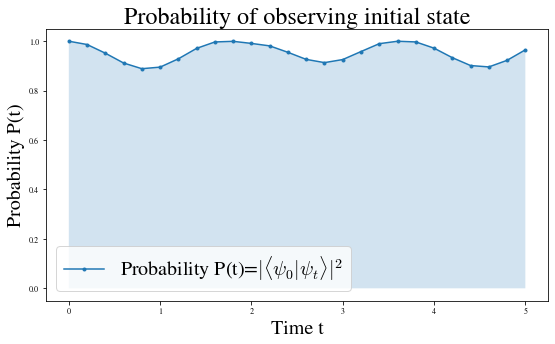

In [1696]:
plt.figure(figsize=(9,5))
plt.plot(t,overlapsvar2,".-" ,label=r'Probability P(t)=$|\langle \psi_0 | \psi_t \rangle|^2$')
plt.fill_between(t, 0, overlapsvar2, alpha=0.2)
plt.legend(fontsize=20)
plt.xlabel('Time t', fontsize=20)
plt.ylabel('Probability P(t)', fontsize=20)
plt.title('Probability of observing initial state', fontsize=24)

(0.0, 1.1)

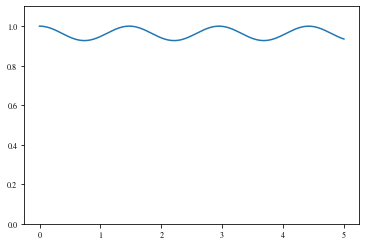

In [1697]:
init_vect=init_state.construct_circuit("vector").flatten()
if theta_list[0] != [0,0,0]:
    init_state_qutip=qt.Qobj(np.around(var_mat_cir(theta_list[0])
[1],4)@init_vect)
else: 
    init_state_qutip=init_state.construct_circuit("qutip")
tlist = np.linspace(0, tfin, 5001)

H_qutip=qt.Qobj(to_matrix_operator(H).dense_matrix) 
sol=qt.sesolve(H_qutip, init_state_qutip, tlist) 
#sol.states[0].full().flatten()
overlapexact=np.asarray([ np.square(np.abs(qiskit_overlap(sol.states[0].full().flatten(), qtstate.full().flatten()))) for qtstate in sol.states])
plt.plot(tlist,overlapexact)
plt.ylim((0,1.1))

In [1683]:
import seaborn as sns

In [1]:


[time,evolvetrotter,qmatrix]=qiskit_trotter_simulate(Hamilton=H,init_state=init_state, t_stepsize=delta_t, nsteps=nstep-1)

overlaps_trotter= np.asarray([ np.square(np.abs(qiskit_overlap(init_vect, evolve))) for evolve in evolvetrotter])

NameError: name 'qiskit_trotter_simulate' is not defined

In [2]:
##### plottino

plt.figure(figsize=(10,3.6))
plt.plot(tlist, overlapexact, label = r'exact')
plt.fill_between(tlist, 0, overlapexact, alpha=0.4)

plt.plot(t, overlapsvar2, 'o-', label = r'Var, $ \Delta_t $= '+str(delta_t))

plt.plot(time, overlaps_trotter, 'o-', label = r'Trotter,  $ \Delta_t $= '+str(delta_t))

plt.ylim(0,1.1)
plt.xticks([0,1,2,3,4,5],fontsize=22)
plt.yticks(fontsize=22)
plt.title(r'$|\langle \psi | e^{iHt} | \psi \rangle|^2$, initial state $ \, | \psi \rangle=o \rightarrow o$, m='+ str(params["m"]/params["e"]) +' e', fontsize=17)
plt.xlabel(r'Time $t$', fontsize=22)
plt.legend(fontsize=17)#, loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

NameError: name 'plt' is not defined

In [1522]:
str(params["m"]/params["e"]) 

'1.0'

(0.0, 1.0)

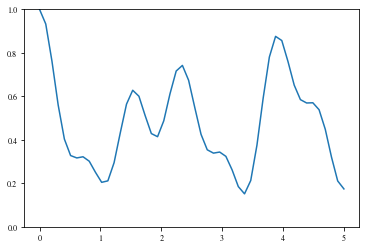

In [1410]:
### penso che quella esatta potrei farla così 
init_state_qutip=init_state.construct_circuit("qutip")
v_check=qt.Qobj(init_state.construct_circuit("vector").flatten())
if theta_list[0] != [0,0,0]:
    init_state_qutip=qt.Qobj(np.around(var_mat_cir(theta_list[0])
[1],4)@init_vect)
    v_check=qt.Qobj(np.around(var_mat_cir(theta_list[0])[1],4)@init_vect)
H_qutip=qt.Qobj(to_matrix_operator(H).dense_matrix)
sol=qt.sesolve(H_qutip, v_check, t)
#plt.plot(t,sol.states)
overlapexact=np.asarray([ np.square(np.abs(qiskit_overlap(sol.states[0].full().flatten(), qtstate.full().flatten()))) for qtstate in sol.states])

plt.plot(t,overlapexact)
plt.ylim((0,1))
# ma vuoldire ceh trotte lo prende male= 

In [1389]:
init_state_qutip=init_state.construct_circuit("qutip")
v_check=qt.Qobj(init_state.construct_circuit("vector").flatten())
init_state_qutip

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

In [1393]:
qt.Qobj(init_state.construct_circuit("vector").flatten())

Quantum object: dims = [[32], [1]], shape = (32, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

### ToDO 
# COnfrntare con exact solution e non solo trotter solution di Simon, vedi come Simone aveva confrontato trotter con exact, o come lo fa la pAuline sul coso oppure vedi se giulia aiuta, oppure se chiami la funzione . Hai cambiato all'ultimo tutte le multiplicazioni matriciali, vedi se non ci sono errori la dentro.
seocndo ci sarebbe da capire se il derUdag, ha senso come é scritto
, seocndo chissà se ora ci sono degli stati non fisici, terzo 
magari il problema é la variational form, se usi 4 lambda dovrebbe andare meglio, sarebbe fico ! 
ricorda che tutto é fatto in statevector !! e che prima o poi servirâ portare tutto in vector mode!!


# ho cambiato l'input del vect, mettendo l'init vect, ma viene tutto 0, vai a vedere perchàéé! 

In [655]:
init_state_zero=Zero(H.num_qubits)
q_init_circ_proof=WilsonLGT2(lattice=lattice, S=S, rep=rep).construct_circuit(parameters=[0,0,0])
q_init_circ_proof.decompose().draw()

┌───┐                                                                  »
q_0: ───┤ H ├──────────────────────────────────────────────────────────────────»
        ├───┤                                          ┌───┐    ┌───┐          »
q_1: ───┤ H ├─────■──────────────────────────■─────────┤ H ├────┤ H ├──■───────»
     ┌──┴───┴──┐┌─┴─┐                      ┌─┴─┐    ┌──┴───┴───┐├───┤┌─┴─┐     »
q_2: ┤ RX(π/2) ├┤ X ├──■─────────────■─────┤ X ├────┤ RX(-π/2) ├┤ H ├┤ X ├──■──»
     ├─────────┤└───┘  │             │     └───┘    └──────────┘└───┘└───┘  │  »
q_3: ┤ RX(π/2) ├───────┼─────────────┼──────────────────────────────────────┼──»
     ├─────────┤     ┌─┴─┐┌───────┐┌─┴─┐┌──────────┐   ┌───┐              ┌─┴─┐»
q_4: ┤ RX(π/2) ├─────┤ X ├┤ RZ(0) ├┤ X ├┤ RX(-π/2) ├───┤ H ├──────────────┤ X ├»
     └─────────┘     └───┘└───────┘└───┘└──────────┘   └───┘              └───┘»
«                                                                     »
«q_0: ────────────────────────────────────────────────────────────────»
«                        ┌───┐┌─────────┐                             »
«q_1: ────────────────■──┤ H ├┤ RX(π/2) ├──■───────────────────────■──»
«                   ┌─┴─┐├───┤├─────────┤┌─┴─┐                   ┌─┴─┐»
«q_2: ───────────■──┤ X ├┤ H ├┤ RX(π/2) ├┤ X ├──■─────────────■──┤ X ├»
«                │  └───┘└───┘└─────────┘└───┘  │             │  └───┘»
«q_3: ───────────┼──────────────────────────────┼─────────────┼───────»
«     ┌───────┐┌─┴─┐┌───┐┌───┐                ┌─┴─┐┌───────┐┌─┴─┐┌───┐»
«q_4: ┤ RZ(0) ├┤ X ├┤ H ├┤ H ├────────────────┤ X ├┤ RZ(0) ├┤ X ├┤ H ├»
«     └───────┘└───┘└───┘└───┘                └───┘└───────┘└───┘└───┘»
«                                                                            »
«q_0: ───────────────────────────────────────────────────────────────────────»
«     ┌──────────┐┌─────────┐                                    ┌──────────┐»
«q_1: ┤ RX(-π/2) ├┤ RX(π/2) ├──■──────────────────────────■──────┤ RX(-π/2) ├»
«     ├──────────┤└──┬───┬──┘┌─┴─┐                      ┌─┴─┐    └──┬───┬───┘»
«q_2: ┤ RX(-π/2) ├───┤ H ├───┤ X ├──■─────────────■─────┤ X ├───────┤ H ├────»
«     └──────────┘   └───┘   └───┘  │             │     └───┘       └───┘    »
«q_3: ──────────────────────────────┼─────────────┼──────────────────────────»
«     ┌─────────┐                 ┌─┴─┐┌───────┐┌─┴─┐┌──────────┐┌─────────┐ »
«q_4: ┤ RX(π/2) ├─────────────────┤ X ├┤ RZ(0) ├┤ X ├┤ RX(-π/2) ├┤ RX(π/2) ├─»
«     └─────────┘                 └───┘└───────┘└───┘└──────────┘└─────────┘ »
«                                                                    ┌───┐┌───┐»
«q_0: ──■─────────────────────────────────────────────────────────■──┤ H ├┤ H ├»
«     ┌─┴─┐                                                     ┌─┴─┐└───┘└───┘»
«q_1: ┤ X ├──■───────────────────────────────────────────■──────┤ X ├──────────»
«     └───┘┌─┴─┐                                       ┌─┴─┐    └───┘          »
«q_2: ─────┤ X ├──■──────────────────────────■─────────┤ X ├───────────────────»
«          └───┘┌─┴─┐                      ┌─┴─┐    ┌──┴───┴───┐┌───┐          »
«q_3: ──────────┤ X ├──■─────────────■─────┤ X ├────┤ RX(-π/2) ├┤ H ├──────────»
«               └───┘┌─┴─┐┌───────┐┌─┴─┐┌──┴───┴───┐└──┬───┬───┘└───┘          »
«q_4: ───────────────┤ X ├┤ RZ(0) ├┤ X ├┤ RX(-π/2) ├───┤ H ├───────────────────»
«                    └───┘└───────┘└───┘└──────────┘   └───┘                   »
«                                                            ┌───┐┌─────────┐»
«q_0: ──■──────────────────────────────────────────────■─────┤ H ├┤ RX(π/2) ├»
«     ┌─┴─┐                                          ┌─┴─┐   └───┘└─────────┘»
«q_1: ┤ X ├──■─────────────────────────────────■─────┤ X ├───────────────────»
«     └───┘┌─┴─┐                             ┌─┴─┐   └───┘                   »
«q_2: ─────┤ X ├──■───────────────────────■──┤ X ├───────────────────────────»
«          └───┘┌─┴─┐                   ┌─┴─┐├───┤┌─────────┐                »
«q_3: ──────

In [777]:
type(derU0dag*derU1)

numpy.ndarray

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [763]:
a=int(input("geben si dein nummer"))

ValueError: invalid literal for int() with base 10: '1.5'

0.9166666666666666